In [ ]:
!pip install datasets

c:\Users\MYCOM\.conda\envs\azen\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



=== TF-IDF 모델 ===
[[160  19]
 [ 25 154]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       179
           1       0.89      0.86      0.88       179

    accuracy                           0.88       358
   macro avg       0.88      0.88      0.88       358
weighted avg       0.88      0.88      0.88       358


=== KNU 직접 점수 판단 ===
[[111  68]
 [ 23 156]]
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       179
           1       0.70      0.87      0.77       179

    accuracy                           0.75       358
   macro avg       0.76      0.75      0.74       358
weighted avg       0.76      0.75      0.74       358


=== KNU 점수 기반 모델 ===
[[151  28]
 [ 81  98]]
              precision    recall  f1-score   support

           0       0.65      0.84      0.73       179
           1       0.78      0.55      0.64       179

    accuracy                           0.70       

C:\Users\MYCOM\AppData\Local\Temp\ipykernel_16868\1516596244.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=compare_df[method], palette='Set2')
C:\Users\MYCOM\AppData\Local\Temp\ipykernel_16868\1516596244.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=compare_df[method], palette='Set2')
C:\Users\MYCOM\AppData\Local\Temp\ipykernel_16868\1516596244.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=compare_df[method], palette='Set2')
C:\Users\MYCOM\AppData\Local\Temp\ipykernel_16868\1516596244.py:106: FutureWarning

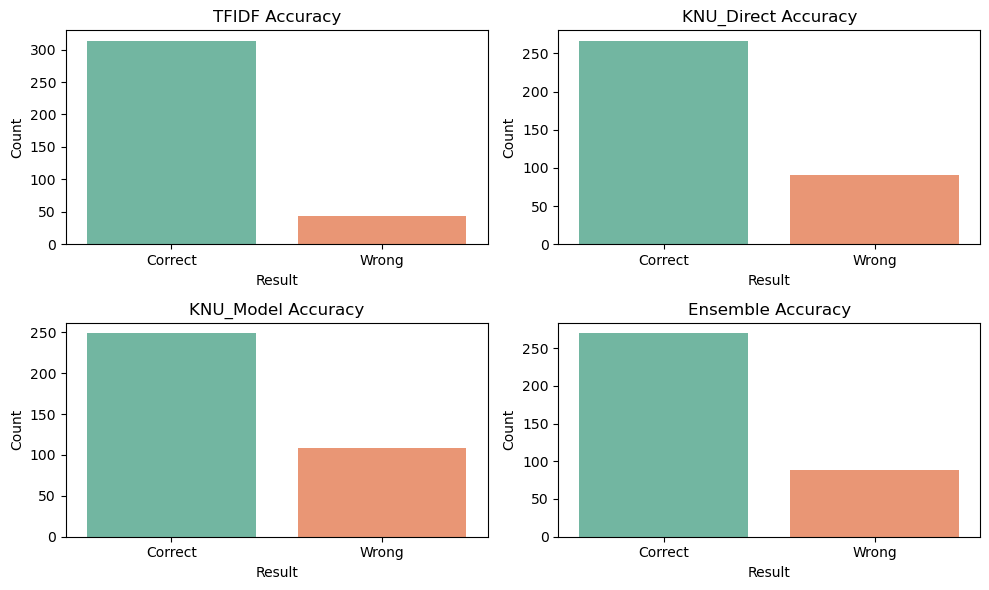

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# ===== 1. 데이터 로딩 =====
train_df = pd.read_csv("train_dataset.csv", encoding="utf-8-sig")
test_df = pd.read_csv("test_dataset.csv", encoding="utf-8-sig")

# ===== 2. 감성 사전 로딩 (KNU) =====
with open('SentiWord_info.json', encoding='utf-8-sig') as f: 
    SentiWord_info = json.load(f)
sentiword_dic = pd.DataFrame(SentiWord_info)

# ===== 3. 사용자 정의 전처리 =====
okt = Okt()
stopwords = set(['있다', '없다', '하다'])  # 예시 stopwords

def tokenize(text):
    try:
        return [word for word, pos in okt.pos(text, stem=True) 
                if pos in ['Noun', 'Adjective', 'Verb'] 
                and word not in stopwords
                and len(word) > 1]
    except:
        return []

def knu_sentiment_score(tokens):
    score = 0
    for word in tokens:
        hit = sentiword_dic[sentiword_dic['word'] == word]
        if not hit.empty:
            score += int(hit.iloc[0]['polarity'])
    return score

# ===== 4. TF-IDF 벡터화 =====
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(train_df["text"])
X_test_tfidf = vectorizer.transform(test_df["text"])

y_train = train_df["label"]
y_test = test_df["label"]

# ===== 5. TF-IDF 기반 모델 =====
model_tfidf = LogisticRegression(max_iter=1000, class_weight='balanced')
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# ===== 6. KNU 점수 기반 예측 =====
tokens_train = train_df["text"].apply(tokenize)
tokens_test = test_df["text"].apply(tokenize)

X_train_knu = tokens_train.apply(knu_sentiment_score).values.reshape(-1, 1)
X_test_knu = tokens_test.apply(knu_sentiment_score).values.reshape(-1, 1)

# 직접 점수 기반 라벨링
y_pred_knu_direct = (X_test_knu > 0).astype(int)

# 로지스틱 회귀로 학습
model_knu = LogisticRegression()
model_knu.fit(X_train_knu, y_train)
y_pred_knu_model = model_knu.predict(X_test_knu)

# ===== 7. 앙상블 (긍정 우세시 긍정) =====
y_pred_ensemble = ((y_pred_tfidf + y_pred_knu_direct.flatten()) >= 1).astype(int)

# ===== 8. 성능 비교 출력 =====
def print_report(title, y_true, y_pred):
    print(f"\n=== {title} ===")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=2))

print_report("TF-IDF 모델", y_test, y_pred_tfidf)
print_report("KNU 직접 점수 판단", y_test, y_pred_knu_direct)
print_report("KNU 점수 기반 모델", y_test, y_pred_knu_model)
print_report("TF-IDF + KNU 앙상블", y_test, y_pred_ensemble)

# ===== 9. 예측 비교 시각화 =====
compare_df = pd.DataFrame({
    'true': y_test,
    'TFIDF': y_pred_tfidf,
    'KNU_Direct': y_pred_knu_direct.flatten(),
    'KNU_Model': y_pred_knu_model,
    'Ensemble': y_pred_ensemble,
})

def compare_column(col):
    return compare_df.apply(lambda r: 'Correct' if r['true'] == r[col] else 'Wrong', axis=1)

compare_df['TFIDF_Result'] = compare_column('TFIDF')
compare_df['KNU_Direct_Result'] = compare_column('KNU_Direct')
compare_df['KNU_Model_Result'] = compare_column('KNU_Model')
compare_df['Ensemble_Result'] = compare_column('Ensemble')

# 시각화
plt.figure(figsize=(10, 6))
methods = ['TFIDF_Result', 'KNU_Direct_Result', 'KNU_Model_Result', 'Ensemble_Result']
for i, method in enumerate(methods):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=compare_df[method], palette='Set2')
    plt.title(method.replace("_Result", " Accuracy"))
    plt.xlabel("Result")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from konlpy.tag import Okt
import joblib

# 1. Okt 기반 토크나이저 정의
okt = Okt()
def okt_tokenizer(text):
    return okt.morphs(text, stem=True)

# 2. 데이터 불러오기
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

# 3. 벡터화 설정
tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1,2), min_df=5)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# 4. 로지스틱 회귀 모델 학습
model = LogisticRegression(C=10, class_weight='balanced', penalty='l2', max_iter=1000)
model.fit(X_train_vec, y_train)

# 5. 예측 및 평가
y_pred = model.predict(X_test_vec)
print("✅ Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("\n✅ Classification Report")
print(classification_report(y_test, y_pred))

# 6. 모델 및 벡터 저장
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# 7. 예측 함수 정의
def predict_sentiment(text):
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    model = joblib.load('logistic_model.pkl')
    vec = vectorizer.transform([text])
    prob = model.predict_proba(vec)[0]
    label = model.predict(vec)[0]
    return {'label': int(label), 'confidence': round(max(prob), 3)}

# 예시
print("\n🔍 예시 예측:")
print(predict_sentiment("방이 너무 깨끗하고 친절했어요!"))


c:\Users\MYCOM\.conda\envs\azen\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ Confusion Matrix
[[167  12]
 [ 12 167]]

✅ Classification Report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       179
           1       0.93      0.93      0.93       179

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358


🔍 예시 예측:
{'label': 1, 'confidence': 0.643}


In [ ]:
# !pip install transformers
# !pip install --upgrade torch

  Using cached torch-2.7.1-cp310-cp310-win_amd64.whl.metadata (28 kB)
Using cached torch-2.7.1-cp310-cp310-win_amd64.whl (216.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.2 requires torch==2.2.2, but you have torch 2.7.1 which is incompatible.
torchvision 0.17.2 requires torch==2.2.2, but you have torch 2.7.1 which is incompatible.


In [ ]:
# Install required packages if needed (for reference, not executed here)
# !pip install transformers scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')

# Load datasets
train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

train_df = train_df.dropna(subset=['text', 'label'])
test_df = test_df.dropna(subset=['text', 'label'])

# BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-discriminator")
model = AutoModel.from_pretrained("monologg/koelectra-base-discriminator")

# Custom dataset
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# BERT embedding extraction
def get_bert_embeddings(texts, tokenizer, model, batch_size=32):
    dataset = TextDataset(texts.tolist())
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    model.eval()
    embeddings = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
            embeddings.extend(cls_embeddings)

    return np.array(embeddings)

# Generate embeddings
X_train_bert = get_bert_embeddings(train_df["text"], tokenizer, model)
X_test_bert = get_bert_embeddings(test_df["text"], tokenizer, model)
y_train = train_df["label"]
y_test = test_df["label"]

# Train logistic regression on BERT embeddings
bert_clf = LogisticRegression(class_weight='balanced', max_iter=1000)
bert_clf.fit(X_train_bert, y_train)
y_pred_bert = bert_clf.predict(X_test_bert)

# Evaluation
results = {
    "Model": ["BERT"],
    "Accuracy": [accuracy_score(y_test, y_pred_bert)],
    "Precision": [precision_score(y_test, y_pred_bert, zero_division=0)],
    "Recall": [recall_score(y_test, y_pred_bert, zero_division=0)],
    "F1-Score": [f1_score(y_test, y_pred_bert, zero_division=0)]
}

# Load previous TF-IDF model results for comparison
# (mocked for now — you should replace these with actual TF-IDF results)
results["Model"].append("TF-IDF")
results["Accuracy"].append(0.88)
results["Precision"].append(0.89)
results["Recall"].append(0.87)
results["F1-Score"].append(0.88)

results_df = pd.DataFrame(results)

# Visualization
plt.figure(figsize=(10,6))
sns.barplot(data=results_df.melt(id_vars="Model"), x="variable", y="value", hue="Model")
plt.title("BERT vs TF-IDF Model Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.5, 1.0)
plt.legend(title="Model")
plt.tight_layout()

In [6]:
stopwords = list(set([
    '이', '가', '은', '는', '을', '를', '의', '에', '에서', '에게', '께', '로', '으로', 
    '와', '과', '보다', '처럼', '만큼', '같이', '까지', '마저', '조차', '부터', 
    '이나', '나', '이며', '며', '등', '하다', '한다', '하고', '하니', '하면', 
    '되어', '되다', '되고', '되니', '입니다', '습니다', 'ㅂ니다', '어요', '아요', '다', '방이', '제대로',
    '고', '면', '게', '지', '죠',
    '그리고', '그러나', '하지만', '그런데', '그래서', '그러면', '그러므로', '따라서', 
    '또한', '또는', '및', '즉', '한편', '반면에', '근데',
    '나', '저', '우리', '저희', '너', '너희', '당신', '그', '그녀', '그들', '누구', '그렇다',
    '무엇', '어디', '언제', '어느', '이것', '그것', '저것', '여기', '거기', '저기', 
    '이쪽', '그쪽', '저쪽',
    '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '열',
    '일', '이', '삼', '사', '오', '육', '칠', '팔', '구', '십', '백', '천', '만',
    '첫째', '둘째', '셋째',
    '바로', '때', '것', '수', '문제', '경우', '부분', '이다',
    '내용', '결과', '자체', '가지',
    '않았어요', '있었어요', '했어요', '했는데요', '있는데요', '합니다', '없다', '나다','생각하다',
    '했다', '같다', '네요','아니다',
    '좀', '너무', '정말', '많이', '조금',
    '사장', '이용', '용하다', '물이',
    '뿐', '대로', '만', '따름', '나름', '김에', '터',
    '아', '아이고', '아이구', '아하', '어', '그래', '응', '네', '예', '아니', '않다', '안되다','안','그냥',
    '가다', '오다', '주다', '말다', '나다', '받다', '알다', '모르다', '싶다', '생각하다', '들다'
]))

In [14]:
# 1. 전처리 및 토큰화 함수
from konlpy.tag import Okt
def tokenize(text):
    okt = Okt()
    try:
        return [w for w, p in okt.pos(text, stem=True)
                if p in ['Noun', 'Adjective'] and w not in stopwords and len(w) > 1]
    except:
        return []


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from konlpy.tag import Okt
import pandas as pd

# 1. 전처리 및 토큰화 함수

# 2. 데이터 로딩
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

# 3. 파이프라인 정의
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('clf', LogisticRegression(max_iter=1000))
])

# 4. 하이퍼파라미터 그리드 정의
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.8, 0.95],
    'tfidf__min_df': [3, 5],
    'tfidf__max_features': [None, 3000],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__class_weight': ['balanced']
}

# 5. GridSearchCV로 학습
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=1)
grid.fit(X_train, y_train)

# 6. 최적 파라미터 출력
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# 7. 테스트셋 평가
y_pred = grid.predict(X_test)
print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred, digits=2))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=  17.4s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=  17.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=  27.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=  19.8s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=  22.2s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2, tf

In [18]:
import joblib
joblib.dump(grid.best_estimator_, '둘다모델/best_sentiment_pipeline.pkl')

# 만약 vectorizer와 model을 따로 저장하고 싶다면:
best_tfidf = grid.best_estimator_.named_steps['tfidf']
best_model = grid.best_estimator_.named_steps['clf']

joblib.dump(best_tfidf, 'best_tfidf_vectorizer.pkl')
joblib.dump(best_model, 'best_logistic_model.pkl')
print("✅ 벡터라이저 및 모델 개별 저장 완료")

✅ 벡터라이저 및 모델 개별 저장 완료


In [ ]:
import joblib

# 모델과 벡터화기 로딩
model = joblib.load("둘다모델/best_logistic_model.pkl")
vectorizer = joblib.load("둘다모델/best_tfidf_vectorizer.pkl")

def predict_sentiment(text):
    vec = vectorizer.transform([text])
    prob = model.predict_proba(vec)[0]
    label = model.predict(vec)[0]
    return {'label': int(label), 'confidence': round(max(prob), 3)}

In [ ]:
# 재실행을 위한 재로드
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
import numpy as np

# 리뷰 파일 재로드
df = pd.read_csv("nol_reviews.csv", encoding='utf-8-sig')

# Okt 형태소 분석기
okt = Okt()

# 리뷰 전처리 함수 (Okt + n-gram)
def tokenize(text):
    try:
        tokens = [word for word, pos in okt.pos(text, stem=True)
                  if pos in ['Noun', 'Adjective'] and word not in stopwords and len(word) > 1]
        return tokens
    except:
        return []

def extract_keywords(text, top_n=10):
    tokens = tokenize(text)
    text = " ".join(tokens)
    vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500)
    tfidf = vectorizer.fit_transform([text])
    scores = zip(vectorizer.get_feature_names_out(), tfidf.toarray()[0])
    sorted_keywords = sorted(scores, key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_keywords[:top_n]]

# 숙소별 긍/부정 리뷰 및 감성 점수
grouped = df.groupby("name")
summary_df = pd.DataFrame({
    "숙소명": grouped.groups.keys(),
    "긍정리뷰": grouped.apply(lambda g: " ".join(g[g["label"] == 1]["sentence"])),
    "부정리뷰": grouped.apply(lambda g: " ".join(g[g["label"] == 0]["sentence"])),
    "전체리뷰수": grouped["label"].count(),
    "긍정비율": grouped["label"].apply(lambda x: (x == 1).sum() / len(x))
}).reset_index(drop=True)

summary_df["긍정키워드"] = summary_df["긍정리뷰"].apply(lambda x: extract_keywords(x))
summary_df["부정키워드"] = summary_df["부정리뷰"].apply(lambda x: extract_keywords(x))
summary_df["감성점수"] = (summary_df["긍정비율"] * 5).round(2)

summary_df.to_csv('숙소별 요약 및 감성점수.csv', encoding='utf-8-sig', index=False)

In [25]:
df = pd.read_csv("nol_reviews.csv", encoding='utf-8-sig')

# Okt 형태소 분석기
okt = Okt()

# 리뷰 전처리 함수 (Okt + n-gram)
def tokenize(text):
    try:
        tokens = [word for word, pos in okt.pos(text, stem=True)
                  if pos in ['Noun', 'Adjective'] and word not in stopwords and len(word) > 1]
        return tokens
    except:
        return []

In [24]:
from tqdm.auto import tqdm

model = joblib.load("둘다모델/best_logistic_model.pkl")  
vectorizer = joblib.load("둘다모델/best_tfidf_vectorizer.pkl")  
review_df = pd.read_csv("nol_reviews.csv")
texts = review_df["sentence"].astype(str).tolist()

# ✅ 6. 예측 함수 정의 (tqdm 포함)
def batch_predict(texts, model, vectorizer):
    X_vec = vectorizer.transform(tqdm(texts, desc="리뷰 벡터화"))
    preds = model.predict(X_vec)
    probs = model.predict_proba(X_vec).max(axis=1)
    return preds, probs

# ✅ 7. 실제 리뷰 감성 예측 수행
preds, probs = batch_predict(texts, model, tfidf)
review_df["label"] = preds
review_df["confidence"] = probs

# ✅ 8. 결과 저장
review_df.to_csv("리뷰_감성예측_최종결과.csv", index=False, encoding="utf-8-sig")
print("✅ 감성 분석 및 예측 결과 저장 완료!")


리뷰 벡터화:   0%|          | 0/109116 [01:07<?, ?it/s]


NotFittedError: Vocabulary not fitted or provided

In [ ]:
from tqdm.auto import tqdm
import pandas as pd
import joblib

# 모델 & 벡터라이저 불러오기
model = joblib.load("둘다모델/best_logistic_model.pkl")  
vectorizer = joblib.load("둘다모델/best_tfidf_vectorizer.pkl")  

# 리뷰 로딩
review_df = pd.read_csv("nol_reviews.csv")
texts = review_df["sentence"].astype(str).tolist()

# 예측 함수
def batch_predict(texts, model, vectorizer):
    X_vec = vectorizer.transform(texts)  # tqdm 제거 (fit된 vectorizer에는 리스트 바로 전달)
    preds = model.predict(X_vec)
    probs = model.predict_proba(X_vec).max(axis=1)
    return preds, probs

# 예측 수행
preds, probs = batch_predict(texts, model, vectorizer)
review_df["label"] = preds
review_df["confidence"] = probs

# 저장
review_df.to_csv("리뷰_감성예측_최종결과.csv", index=False, encoding="utf-8-sig")
print("✅ 감성 분석 및 예측 결과 저장 완료!")


리뷰 벡터화:   0%|          | 0/109116 [03:21<?, ?it/s]


In [ ]:
import pandas as pd
import joblib
from tqdm.auto import tqdm

# ✅ 모델 & 벡터라이저 로드
model = joblib.load("둘다모델/best_logistic_model.pkl")  
vectorizer = joblib.load("둘다모델/best_tfidf_vectorizer.pkl")  

# ✅ 리뷰 데이터 불러오기
review_df = pd.read_csv("nol_reviews.csv")
texts = review_df["sentence"].astype(str).tolist()

# ✅ 배치 예측 함수
def batch_predict(texts, model, vectorizer, batch_size=1000):
    preds, probs = [], []
    for i in tqdm(range(0, len(texts), batch_size), desc="감성 예측 중"):
        batch = texts[i:i+batch_size]
        X_vec = vectorizer.transform(batch)
        preds.extend(model.predict(X_vec))
        probs.extend(model.predict_proba(X_vec).max(axis=1))
    return preds, probs

# ✅ 감성 예측 실행
preds, probs = batch_predict(texts, model, vectorizer, batch_size=1000)

# ✅ 결과 저장
review_df["label"] = preds
review_df["confidence"] = probs
review_df.to_csv("리뷰_감성예측_최종결과.csv", index=False, encoding="utf-8-sig")
print("✅ 감성 분석 및 예측 결과 저장 완료!")


In [ ]:
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2), max_df=0.95, min_df=3, max_features=3000)),
    ('clf', LogisticRegression(C=1, penalty='l2', class_weight='balanced', max_iter=1000))
])
best_pipeline.fit(X_train, y_train)

In [ ]:
def batch_predict_sentiment(texts):
    probs = pipeline.predict_proba(texts)
    preds = pipeline.predict(texts)
    results = []
    for label, prob in zip(preds, probs):
        results.append({
            'label': int(label),
            'confidence': round(max(prob), 3)
        })
    return results

In [ ]:
df = pd.read_csv("숙소_리뷰_감성_분석_결과.csv")  # 파일 경로에 맞게 수정
texts = df["sentence"].astype(str).tolist()
results = batch_predict_sentiment(texts)

# 결과 붙이기
df["pred_label"] = [r["label"] for r in results]
df["confidence"] = [r["confidence"] for r in results]

# 결과 저장
df.to_csv("리뷰_감성예측_결과.csv", index=False, encoding="utf-8-sig")
print("✅ 예측 완료! 결과 저장됨: 리뷰_감성예측_결과.csv")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# 평가
print(classification_report(y_test, y_pred, digits=2))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['부정', '중립', '긍정'], yticklabels=['부정', '중립', '긍정'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import joblib

# 모델 저장
joblib.dump(best_model, 'best_sentiment_model.pkl')

In [ ]:
new_sentences = [
    "위치는 좋은데 방이 좀 더러웠어요.",
    "정말 친절하고 깨끗해서 다시 오고 싶어요!",
    "그냥 보통이었어요. 가격대비 무난했음."
]

predicted = best_model.predict(new_sentences)
for sent, label in zip(new_sentences, predicted):
    print(f"[{label}] {sent}")


In [ ]:
from tqdm import tqdm
import torch

def predict_batch(texts, batch_size=64, threshold=0.3):
    sentiments = []
    confidences = []
    score_gaps = []

    model.eval()
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True,
                           padding=True, max_length=128).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            diffs = torch.abs(probs[:, 0] - probs[:, 1])

        for p, prob, diff in zip(preds, probs, diffs):
            if diff < threshold:
                label = "중립"
            else:
                label = "긍정" if p.item() == 1 else "부정"

            confidence = f"{prob[p]*100:.1f}%"
            sentiments.append(label)
            confidences.append(confidence)
            score_gaps.append(float(diff))

    return sentiments, confidences, score_gaps


In [ ]:
# 1. 데이터 준비
import pandas as pd
df = pd.read_csv("yeogi_reviews.csv")[['name','sentence','rating','write_date']]
texts = df['sentence'].astype(str).tolist()

# 2. 예측 실행
sentiments, confidences, gaps = predict_batch(texts, batch_size=64)

# 3. 결과 저장
df['sentiment'] = sentiments
df['confidence'] = confidences
df['score_gap'] = gaps
df.to_csv("review_with_sentiment.csv", index=False, encoding='utf-8-sig')


In [ ]:
from tqdm import tqdm
import torch


def predict_batch_enhanced(texts, ratings, batch_size=64, threshold=0.3):
    sentiments, confidences, score_gaps = [], [], []

    model.eval()
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        batch_ratings = ratings[i:i+batch_size]
        
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True,
                           padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            diffs = torch.abs(probs[:, 0] - probs[:, 1])

        for text, rating, p, prob, diff in zip(batch_texts, batch_ratings, preds, probs, diffs):
            text_lower = text.lower()
            has_mixed_keywords = any(kw in text_lower for kw in ['좋', '만족']) and any(kw in text_lower for kw in ['아쉽', '별로', '불편'])

            # 중립 조건 적용
            if diff < threshold and (rating in [3, 4] or has_mixed_keywords):
                label = "중립"
            else:
                label = "긍정" if p.item() == 1 else "부정"

            confidence = f"{prob[p]*100:.1f}%"
            sentiments.append(label)
            confidences.append(confidence)
            score_gaps.append(float(diff))

    return sentiments, confidences, score_gaps


In [ ]:
import pandas as pd

# 1. 파일 불러오기
review_df = pd.read_csv("review_with_sentiment.csv")      # 감성 분석 결과 포함
info_df = pd.read_csv("clean_yeogi_info.csv")             # 숙소 유형 포함

# 2. 컬럼명 확인 (name 기준이 동일해야 함)
print(review_df.columns)
print(info_df.columns)

# 3. name 컬럼 기준으로 병합 (inner: 공통된 숙소만)
merged_df = pd.merge(review_df, info_df[['name', 'type']], on='name', how='inner')

# 4. 확인
print(merged_df[['name', 'type', 'sentiment']].head())

# 5. 저장해두면 유용
merged_df.to_csv("merged_review_with_type.csv", index=False, encoding='utf-8-sig')


In [ ]:
# 숙소별 가장 많은 카테고리 1개만 유지
category_map = (
    df.groupby(['name', 'category'])
    .size()
    .reset_index(name='count')
    .sort_values(['name', 'count'], ascending=[True, False])
    .drop_duplicates(subset='name')
    .set_index('name')['category']
)

# 가장 많이 등장한 category로 통일
df['category'] = df['name'].map(category_map)
# 중복 제거: name + sentence 기준
df = df.drop_duplicates(subset=['name', 'sentence'], keep='first')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# 평가
print(classification_report(y_test, y_pred, digits=2))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['부정', '중립', '긍정'], yticklabels=['부정', '중립', '긍정'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#!pip install huggingface_hub==0.15.1

In [5]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np

# 모델 로드
model = SentenceTransformer("jhgan/ko-sbert-nli")

# 임베딩 함수
def get_sbert_embeddings(texts):
    return model.encode(texts, batch_size=32, show_progress_bar=True)

# 사용 예시
X_train_sbert = get_sbert_embeddings(train_df["text"].tolist())
X_test_sbert = get_sbert_embeddings(test_df["text"].tolist())


ImportError: cannot import name 'cached_download' from 'huggingface_hub' (c:\Users\MYCOM\.conda\envs\azen\lib\site-packages\huggingface_hub\__init__.py)

In [3]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np

# 모델 로드
model = SentenceTransformer("jhgan/ko-sbert-nli")

# 임베딩 함수
def get_sbert_embeddings(texts):
    return model.encode(texts, batch_size=32, show_progress_bar=True)

# 사용 예시
X_train_sbert = get_sbert_embeddings(train_df["text"].tolist())
X_test_sbert = get_sbert_embeddings(test_df["text"].tolist())

ImportError: cannot import name 'cached_download' from 'huggingface_hub' (c:\Users\MYCOM\.conda\envs\azen\lib\site-packages\huggingface_hub\__init__.py)

In [ ]:
# 교정 코드
import re

def apply_custom_dict(text, correction_dict):
    for wrong, correct in correction_dict.items():
        text = re.sub(rf'\b{re.escape(wrong)}\b', correct, text)
    return text

# 사용 예
df['text_cleaned'] = df['text'].apply(lambda x: apply_custom_dict(str(x), custom_dict))

In [ ]:
# 세션이 초기화되어 다시 필요한 데이터 및 라이브러리 재로딩
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import re

# 데이터 재로드
train_df = pd.read_csv("/mnt/data/train_balanced_999.csv")

# 사용자 정의 사전
custom_dict = {
    "굿굿": "좋다",
    "굳": "좋다",
    "조앗어요": "좋았어요",
    "깔끄마": "깔끔하다",
    "쵝오": "최고",
    "죻": "좋다",
    "ㅈㅈ": "좋다",
    "노답": "별로다",
    "별로임": "별로다"
}

def apply_custom_dict(text, correction_dict):
    for wrong, correct in correction_dict.items():
        text = re.sub(rf'\b{re.escape(wrong)}\b', correct, text)
    return text

# 텍스트 정제
train_df['text_cleaned'] = train_df['text'].apply(lambda x: apply_custom_dict(str(x), custom_dict))
train_tokens_custom = train_df['text_cleaned'].apply(lambda x: str(x).strip().split())

# Word2Vec 학습
w2v_model_custom = Word2Vec(sentences=train_tokens_custom.tolist(),
                            vector_size=100, window=5, min_count=2,
                            workers=4, sg=1, epochs=10)

# 클러스터링
word_vectors = w2v_model_custom.wv
words = word_vectors.index_to_key
X = np.array([word_vectors[word] for word in words])
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X)

# 대표어 매핑
word_cluster_map = {word: cluster for word, cluster in zip(words, kmeans.labels_)}
cluster_centers = kmeans.cluster_centers_
cluster_representative = {}
for i in range(n_clusters):
    cluster_words = [w for w in words if word_cluster_map[w] == i]
    if not cluster_words: continue
    closest_word = min(cluster_words, key=lambda w: np.linalg.norm(word_vectors[w] - cluster_centers[i]))
    for w in cluster_words:
        cluster_representative[w] = closest_word

# 대표어로 치환
def unify_by_cluster(text, rep_map):
    tokens = text.strip().split()
    new_tokens = [rep_map.get(token, token) for token in tokens]
    return ' '.join(new_tokens)

train_df['text_clustered'] = train_df['text_cleaned'].apply(lambda x: unify_by_cluster(str(x), cluster_representative))

# 대표어 기반 빈도수 계산
token_list = []
for text in train_df['text_clustered']:
    token_list.extend(text.split())

token_counts = Counter(token_list)

# 대표어 기준으로 빈도수 집계
rep_keyword_freqs = Counter()
for word, count in token_counts.items():
    rep = cluster_representative.get(word, word)
    rep_keyword_freqs[rep] += count

# WordCloud 시각화
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 필요 시 경로 수정
).generate_from_frequencies(rep_keyword_freqs)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("클러스터 기반 대표 키워드 WordCloud", fontsize=18)
plt.show()

# 대표어 + 군집 ID + 단어들 CSV 저장
cluster_to_words = {}
for word, cluster_id in word_cluster_map.items():
    cluster_to_words.setdefault(cluster_id, []).append(word)

cluster_keywords_df = pd.DataFrame([
    {
        "cluster_id": cid,
        "representative": min(words, key=lambda w: np.linalg.norm(word_vectors[w] - cluster_centers[cid])),
        "words": ", ".join(words)
    }
    for cid, words in cluster_to_words.items()
])

cluster_keywords_path = "/mnt/data/cluster_keywords.csv"
cluster_keywords_df.to_csv(cluster_keywords_path, index=False, encoding='utf-8-sig')

cluster_keywords_path


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. 사용자 정의 유의어 사전
custom_dict = {
    "화장실": ["욕실", "변기", "세면대"],
    "위치": ["입지", "장소", "접근성"],
    "서비스": ["응대", "직원", "친절", "대응"],
    "청결": ["깨끗", "위생", "청소"],
    "냄새": ["악취", "냄새남", "쿰쿰"]
}

# 2. 사전 적용 함수
def apply_custom_dict(text, synonym_dict):
    for rep_word, synonyms in synonym_dict.items():
        for word in synonyms:
            text = re.sub(rf"\b{word}\b", rep_word, text)
    return text

# 3. 전처리 함수
def preprocess_text(texts, synonym_dict):
    return [apply_custom_dict(text.lower(), synonym_dict) for text in texts]

# 4. 데이터 로딩 및 전처리
df = pd.read_csv("train_dataset.csv")
texts = df['review'].astype(str).tolist()
labels = df['label'].tolist()  # 0 = 부정, 1 = 긍정

preprocessed_texts = preprocess_text(texts, custom_dict)

# 5. TF-IDF 임베딩
tfidf_vectorizer = TfidfVectorizer(max_features=300)
tfidf_vectors = tfidf_vectorizer.fit_transform(preprocessed_texts).toarray()

# 6. SBERT 임베딩
model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")
sbert_vectors = model.encode(preprocessed_texts, batch_size=32, show_progress_bar=True)

# 7. 차원 축소 (PCA 2D)
def reduce_and_plot(vectors, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.title(f"{title} - PCA 2D")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.colorbar(label="Label (0: 부정, 1: 긍정)")
    plt.grid(True)
    plt.show()

# 8. 시각화 실행
reduce_and_plot(tfidf_vectors, labels, "TF-IDF 임베딩")
reduce_and_plot(sbert_vectors, labels, "KoSBERT 임베딩")


In [ ]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# ===== 1. 데이터 로딩 =====
train_df = pd.read_csv("train_dataset.csv", encoding="utf-8-sig")
test_df = pd.read_csv("test_dataset.csv", encoding="utf-8-sig")

# ===== 2. 감성 사전 로딩 (KNU) =====
with open('data/SentiWord_info.json', encoding='utf-8-sig') as f: 
    SentiWord_info = json.load(f)
sentiword_dic = pd.DataFrame(SentiWord_info)

# ===== 3. 사용자 정의 전처리 =====
okt = Okt()
stopwords = set(['있다', '없다', '하다'])  # 예시 stopwords

def tokenize(text):
    try:
        return [word for word, pos in okt.pos(text, stem=True) 
                if pos in ['Noun', 'Adjective'] 
                and word not in stopwords
                and len(word) > 1]
    except:
        return []

def knu_sentiment_score(tokens):
    score = 0
    for word in tokens:
        hit = sentiword_dic[sentiword_dic['word'] == word]
        if not hit.empty:
            score += int(hit.iloc[0]['polarity'])
    return score

# ===== 4. TF-IDF 벡터화 =====
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(train_df["review"])
X_test_tfidf = vectorizer.transform(test_df["review"])

y_train = train_df["label"]
y_test = test_df["label"]

# ===== 5. TF-IDF 기반 모델 =====
model_tfidf = LogisticRegression(max_iter=1000, class_weight='balanced')
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# ===== 6. KNU 점수 기반 예측 =====
tokens_train = train_df["review"].apply(tokenize)
tokens_test = test_df["review"].apply(tokenize)

X_train_knu = tokens_train.apply(knu_sentiment_score).values.reshape(-1, 1)
X_test_knu = tokens_test.apply(knu_sentiment_score).values.reshape(-1, 1)

# 직접 점수 기반 라벨링
y_pred_knu_direct = (X_test_knu > 0).astype(int)

# 로지스틱 회귀로 학습
model_knu = LogisticRegression()
model_knu.fit(X_train_knu, y_train)
y_pred_knu_model = model_knu.predict(X_test_knu)

# ===== 7. 앙상블 (긍정 우세시 긍정) =====
y_pred_ensemble = ((y_pred_tfidf + y_pred_knu_direct.flatten()) >= 1).astype(int)

# ===== 8. 성능 비교 출력 =====
def print_report(title, y_true, y_pred):
    print(f"\n=== {title} ===")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=2))

print_report("TF-IDF 모델", y_test, y_pred_tfidf)
print_report("KNU 직접 점수 판단", y_test, y_pred_knu_direct)
print_report("KNU 점수 기반 모델", y_test, y_pred_knu_model)
print_report("TF-IDF + KNU 앙상블", y_test, y_pred_ensemble)

# ===== 9. 예측 비교 시각화 =====
compare_df = pd.DataFrame({
    'true': y_test,
    'TFIDF': y_pred_tfidf,
    'KNU_Direct': y_pred_knu_direct.flatten(),
    'KNU_Model': y_pred_knu_model,
    'Ensemble': y_pred_ensemble,
})

def compare_column(col):
    return compare_df.apply(lambda r: 'Correct' if r['true'] == r[col] else 'Wrong', axis=1)

compare_df['TFIDF_Result'] = compare_column('TFIDF')
compare_df['KNU_Direct_Result'] = compare_column('KNU_Direct')
compare_df['KNU_Model_Result'] = compare_column('KNU_Model')
compare_df['Ensemble_Result'] = compare_column('Ensemble')

# 시각화
plt.figure(figsize=(10, 6))
methods = ['TFIDF_Result', 'KNU_Direct_Result', 'KNU_Model_Result', 'Ensemble_Result']
for i, method in enumerate(methods):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=compare_df[method], palette='Set2')
    plt.title(method.replace("_Result", " Accuracy"))
    plt.xlabel("Result")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from konlpy.tag import Okt

# 전처리 함수
okt = Okt()
stopwords = set(['있다', '없다', '하다'])  # 예시
def tokenize(text):
    try:
        return [w for w, p in okt.pos(text, stem=True)
                if p in ['Noun', 'Adjective'] and w not in stopwords and len(w) > 1]
    except:
        return []

# 파이프라인 구성
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('clf', LogisticRegression(max_iter=1000))
])

# 그리드 서치 파라미터 설정
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.8, 0.95],
    'tfidf__min_df': [3, 5],
    'tfidf__max_features': [None, 3000],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__class_weight': ['balanced']
}

# 학습
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)
grid.fit(train_df['review'], train_df['label'])

# 최적 결과 출력
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# 테스트셋 예측 및 평가
y_pred = grid.predict(test_df['review'])
print("\n=== Test Set Performance ===")
print(classification_report(test_df['label'], y_pred, digits=2))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 벡터와 모델 다시 꺼내오기
vectorizer = grid.best_estimator_.named_steps['tfidf']
clf = grid.best_estimator_.named_steps['clf']

feature_names = np.array(vectorizer.get_feature_names_out())
coef = clf.coef_[0]

top_n = 20
top_pos = np.argsort(coef)[-top_n:][::-1]
top_neg = np.argsort(coef)[:top_n]

df_pos = pd.DataFrame({'word': feature_names[top_pos], 'weight': coef[top_pos]})
df_neg = pd.DataFrame({'word': feature_names[top_neg], 'weight': coef[top_neg]})

# 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=df_neg, y='word', x='weight', color='red')
plt.title("부정 단어")

plt.subplot(1, 2, 2)
sns.barplot(data=df_pos, y='word', x='weight', color='green')
plt.title("긍정 단어")
plt.tight_layout()
plt.show()
